# Probabilistic ranking
The results of the 2011 ATM men's tennis singles for 107 players in 1801 games are used to compute the probabilistic rankings of the skills of these players. The skill level of a player is modelled by the TrueSkill model, which is implemented using two methods, Gibbs sampling and expectation propagation.

In [1]:
import scipy.io as sio
from scipy.stats import norm, multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas as pd
from tqdm import tqdm
from cw2 import sorted_barplot
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 14})

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [3]:
np.random.seed(0)

# load data
data = sio.loadmat('tennis_data.mat')
W = np.array([x[0][0] for x in data['W']])
G = data['G'] - 1
M = W.shape[0]    # Number of players
N = G.shape[0]    # Number of Games

# Part a
## Gibbs sampling

In [10]:
skill_samples = gibbs_sample(G, M, 10000)

100%|██████████| 10000/10000 [03:54<00:00, 42.57it/s]


In [11]:
np.save('skill_samples.npy', skill_samples)

In [4]:
skill_samples = np.load('skill_samples.npy')

Text(0, 0.5, 'Skills')

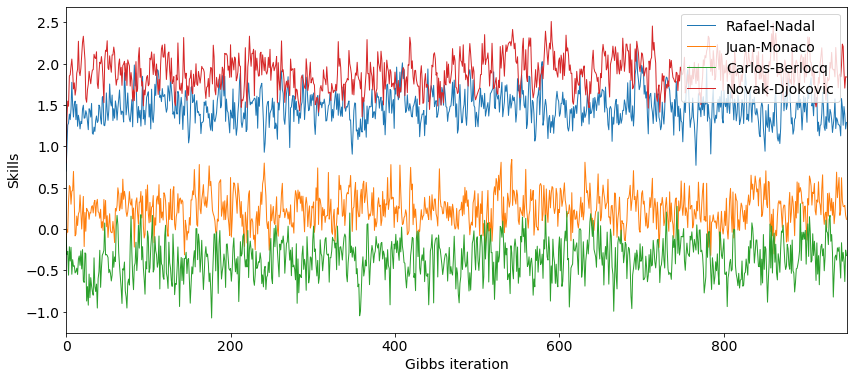

In [5]:
plt.figure(figsize=(14, 6))
for i in [0, 1, 50, 15]:
    plt.plot(skill_samples[i, :950], label=W[i], linewidth=1)
plt.legend(loc='upper right')
plt.xlim(0, 950)
plt.xlabel('Gibbs iteration'); plt.ylabel('Skills')

### Burn-in time
Number of iterations required for the skill samples to enter a region with high probability density.

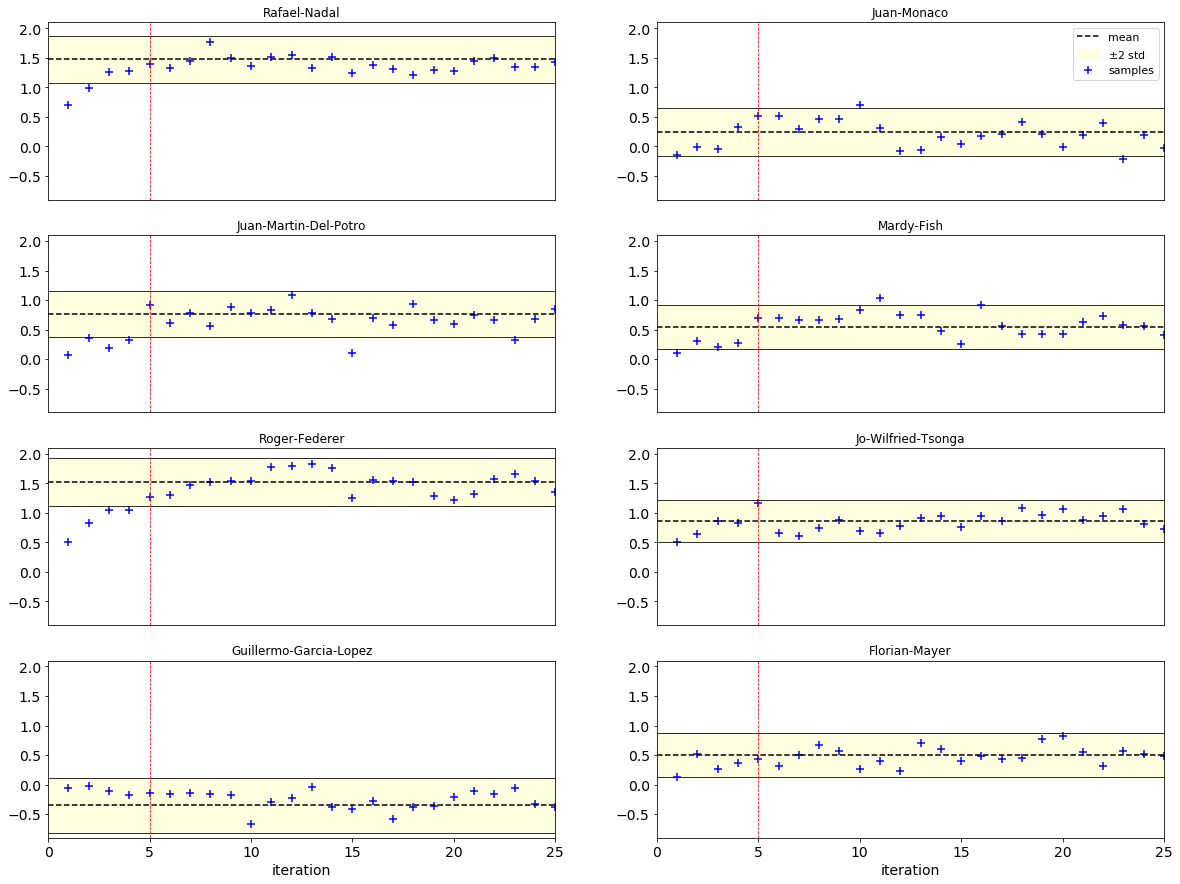

In [6]:
n = 25
plt.figure(figsize=(20, 15))
for p in range(8):
    plt.subplot(4, 2, p+1)
    x = np.linspace(0, n, 1000)
    mean = np.mean(skill_samples[p])
    std = np.std(skill_samples[p])
    
    plt.fill_between(x, mean + 2*std, mean - 2*std, color='lightyellow', label='$\pm$2 std')
    plt.axhline(mean, linestyle='--', color='k', label='mean')
    plt.axhline(mean + 2*std, color='k', linewidth=0.8); plt.axhline(mean - 2*std, color='k', linewidth=0.8)
    plt.scatter(range(1, n+1), skill_samples[p, :n], color='b', marker='+', s=50, label='samples')
    plt.axvline(5, color='r', linewidth=0.8, linestyle='--')
    plt.xlim(0, n)
    plt.ylim(-0.9, 2.1)
    if p < 6:
        plt.xticks([], [])
    else:
        plt.xlabel('iteration')
    if p == 1:
        plt.legend(fontsize=11)
    plt.title(W[p], fontsize=12)

Burn-in time is approximately 5. We will take 20 to be safe.

### Auto-correlation
Thinning is applied so that there is less dependence between samples. This operation does not affect results of later analysis significantly but will save computation time and memory during those calculations.

(0, 25)

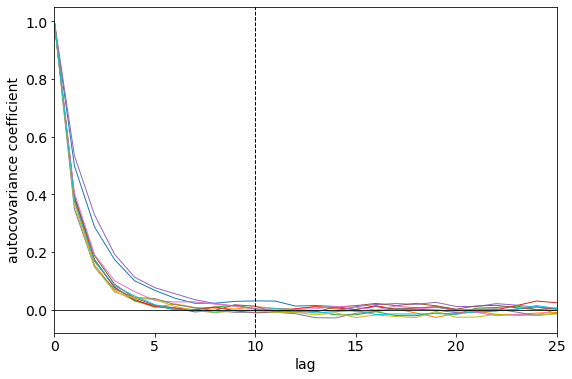

In [13]:
n = 25

plt.figure(figsize=(9, 6))
for p in range(10):
    autocor = [pd.Series.autocorr(pd.Series(skill_samples[p, :]), lag=i) for i in range(n+1)]
    plt.plot(autocor, linewidth=1)

plt.axvline(10, linewidth=1, linestyle='--', color='k')
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('lag'); plt.ylabel('autocovariance coefficient')
plt.xlim(0, n)

At about 10 iterations apart, the samples have close to zero correlation so the thinning factor will be 10.

## Convergence time
The time required for the Markov Chain to reach its stationary distribution, i.e., when the Gibbs samples are sampled from the desired joint posterior.

Text(0, 0.5, 'mean skill')

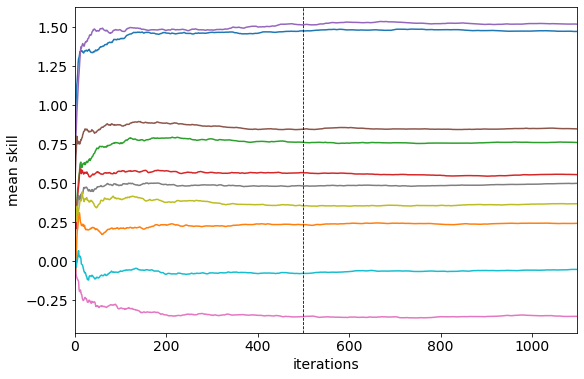

In [15]:
skill_samples_df = pd.DataFrame(skill_samples)
rolling_mean = skill_samples_df.apply(lambda s: s.rolling(window=10000, min_periods=1).mean(), axis=1)
rolling_mean.iloc[:10, :1100].T.plot(legend=False, figsize=(9, 6))
plt.axvline(500, linewidth=0.8, linestyle='--', color='k')
# rolling_mean.mean(axis=0)[:1100].plot()
plt.xlabel('iterations'); plt.ylabel('mean skill')

Text(0, 0.5, 'skill variance')

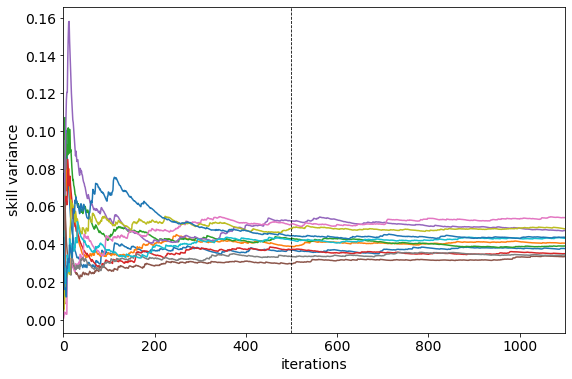

In [16]:
rolling_var = skill_samples_df.apply(lambda s: s.rolling(window=10000, min_periods=1).var(), axis=1)
rolling_var.loc[:10, :1100].T.plot(legend=False, figsize=(9, 6))
plt.axvline(500, linewidth=0.8, linestyle='--', color='k')
plt.xlabel('iterations'); plt.ylabel('skill variance')

The statistics (mean, variance) look fairly steady after 500 iterations.

### Apply burn-in and thinning:

In [17]:
burn_in = 500
thinning = 10
skill_samples_thinned = skill_samples[:, burn_in::thinning]

Text(0, 0.5, 'Skills')

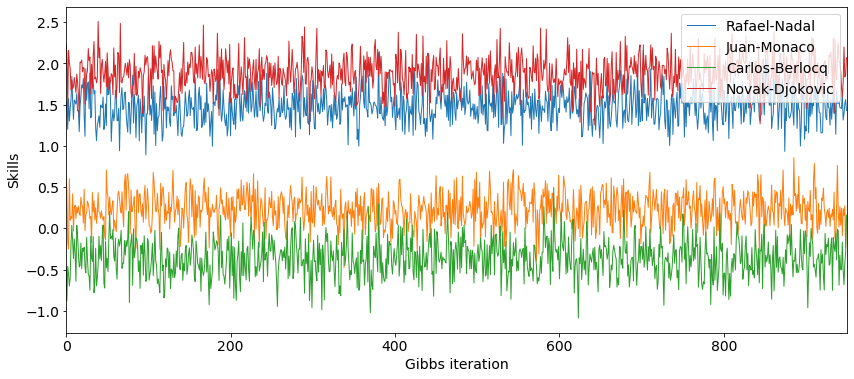

In [25]:
plt.figure(figsize=(14, 6))
for i in [0, 1, 50, 15]:
    plt.plot(skill_samples_thinned[i, :950], label=W[i], linewidth=1)
plt.legend(loc='upper right')
plt.xlim(0, 950)
plt.xlabel('Gibbs iteration'); plt.ylabel('Skills')

New autocorrelation:

(0, 25)

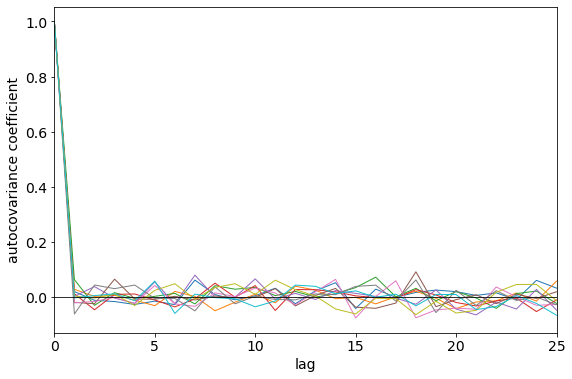

In [542]:
n = 25
autocor = np.zeros(n)

plt.figure(figsize=(9, 6))
for p in range(10):
    autocor = [pd.Series.autocorr(pd.Series(skill_samples[p, ::10]), lag=i) for i in range(n+1)]
    plt.plot(autocor, linewidth=1)

plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('lag'); plt.ylabel('autocovariance coefficient')
plt.xlim(0, n)

In [26]:
mean_player_skills_gs = np.mean(skill_samples_thinned, axis=1)

# Part b
## EP ranking

In [27]:
# test convergence
ep_skills = [eprank(G, M, n_iters) for n_iters in tqdm(range(0, 81))]
mean_player_skills_ep_arr = np.array([ep[0] for ep in ep_skills])
precision_player_skills_ep_arr = np.array([ep[1] for ep in ep_skills])

100%|██████████| 81/81 [00:13<00:00,  6.17it/s]


(0, 80)

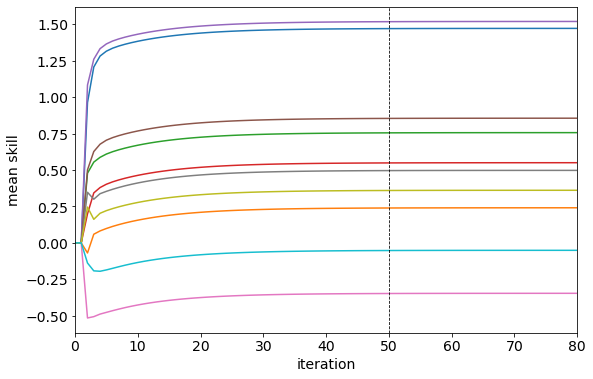

In [28]:
plt.figure(figsize=(9, 6))
for mean in mean_player_skills_ep_arr[:, :10].T:
    plt.plot(mean)

plt.axvline(50, linewidth=0.8, linestyle='--', color='k')
plt.xlabel('iteration'); plt.ylabel('mean skill')
plt.xlim(0, 80)

(0, 80)

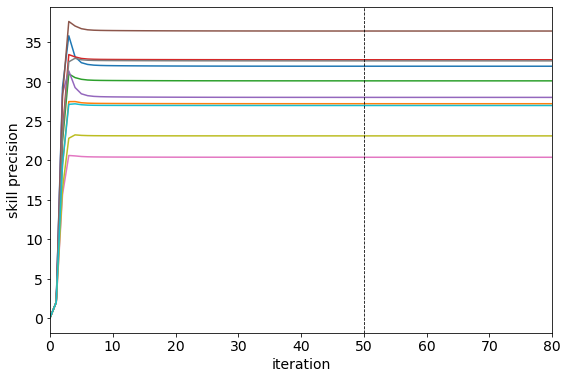

In [29]:
plt.figure(figsize=(9, 6))
for precision in precision_player_skills_ep_arr[:, :10].T:
    plt.plot(precision)

plt.axvline(50, linewidth=0.8, linestyle='--', color='k')
plt.xlabel('iteration'); plt.ylabel('skill precision')
plt.xlim(0, 80)

In [30]:
precision_player_skills_ep = precision_player_skills_ep_arr[-1]
mean_player_skills_ep = mean_player_skills_ep_arr[-1]

### Gibbs sampling convergence - Geweke diagnostic

In [31]:
seq1 = skill_samples_thinned[:, 100:]
seq2 = skill_samples_thinned[:, -500:]

seq1.shape, seq2.shape

((107, 880), (107, 500))

In [32]:
m1, m2 = np.mean(seq1, axis=1), np.mean(seq2, axis=1)
v1, v2 = np.var(seq1, axis=1), np.var(seq2, axis=1)
geweke_z_score = (m1 - m2) / np.sqrt(v1 + v2)

(0, 107)

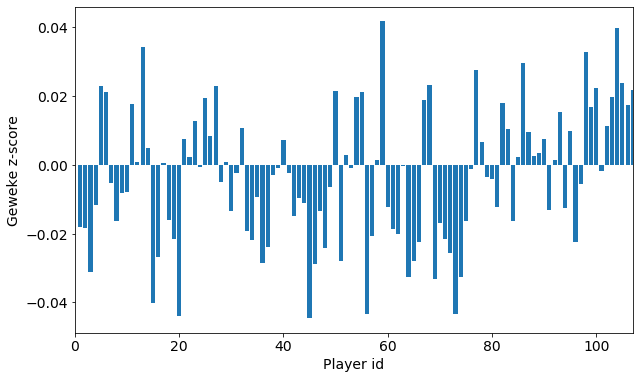

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, M+1), geweke_z_score)
plt.xlabel('Player id'); plt.ylabel('Geweke z-score')
plt.xlim(0, M)

Standard errors are all within $\pm0.05\sigma$. Hence there is no lack of convergence.

# Part c

In [34]:
top4_names = ['Novak-Djokovic', 'Rafael-Nadal', 'Roger-Federer', 'Andy-Murray']
top4_ids = [np.argwhere(W == name)[0][0] for name in top4_names]

top4_ids

[15, 0, 4, 10]

In [35]:
var_player_skills_ep = 1 / precision_player_skills_ep

### 4x4 table: probability that skill of one player is higher than the other

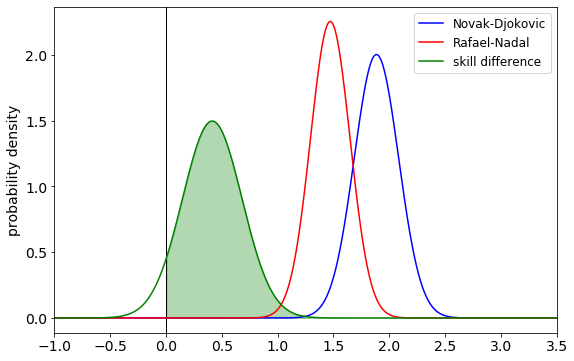

In [564]:
# difference of Gaussians
p1, p2 = top4_ids[0:2]
mu1, v1 = mean_player_skills_ep[p1], var_player_skills_ep[p1]
mu2, v2 = mean_player_skills_ep[p2], var_player_skills_ep[p2]

plt.figure(figsize=(9, 6))
plt.axvline(0, color='k', linewidth=1)
x = np.linspace(-1, 3.5, 1000)
plt.plot(x, norm(mu1, np.sqrt(v1)).pdf(x), color='b', label=top4_names[0])
plt.plot(x, norm(mu2, np.sqrt(v2)).pdf(x), color='r', label=top4_names[1])
plt.plot(x, norm(mu1 - mu2, np.sqrt(v1 + v2)).pdf(x), color='g', label='skill difference')
mask = x > 0
plt.fill_between(x[mask], norm(mu1 - mu2, np.sqrt(v1 + v2)).pdf(x[mask]), 0, color='g', alpha=0.3)
plt.xlim(-1, 3.5)
plt.ylabel('probability density')
plt.legend(fontsize=12)

Proability: area shaded in green

In [36]:
def prob_skill1_gt_skill2(mu1, v1, mu2, v2):
    return norm.cdf((mu1 - mu2) / np.sqrt(v1 + v2))

Generate 4x4 table:

In [37]:
np.array([[prob_skill1_gt_skill2(mean_player_skills_ep[i], var_player_skills_ep[i],
                                 mean_player_skills_ep[j], var_player_skills_ep[j])
          for j in top4_ids] for i in top4_ids])

array([[0.5       , 0.93982264, 0.90888543, 0.98532144],
       [0.06017736, 0.5       , 0.42716909, 0.76651688],
       [0.09111457, 0.57283091, 0.5       , 0.81083465],
       [0.01467856, 0.23348312, 0.18916535, 0.5       ]])

### 4x4 table: probability of one player winning the match between the two

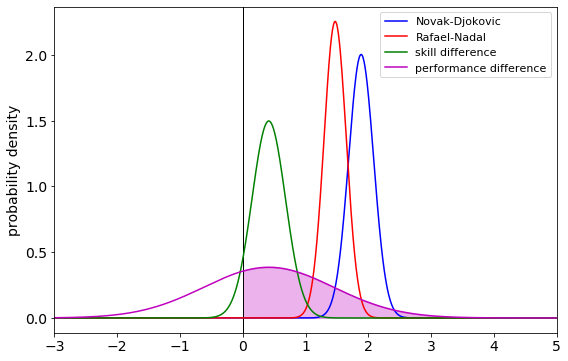

In [38]:
p1, p2 = top4_ids[0:2]
mu1, v1 = mean_player_skills_ep[p1], var_player_skills_ep[p1]
mu2, v2 = mean_player_skills_ep[p2], var_player_skills_ep[p2]

plt.figure(figsize=(9, 6))
plt.axvline(0, color='k', linewidth=1)
x = np.linspace(-3, 5, 1000)
plt.plot(x, norm(mu1, np.sqrt(v1)).pdf(x), color='b', label=top4_names[0])
plt.plot(x, norm(mu2, np.sqrt(v2)).pdf(x), color='r', label=top4_names[1])
plt.plot(x, norm(mu1 - mu2, np.sqrt(v1 + v2)).pdf(x), color='g', label='skill difference')
plt.plot(x, norm(mu1 - mu2, np.sqrt(v1 + v2 + 1)).pdf(x), color='m', label='performance difference')
mask = x > 0
plt.fill_between(x[mask], norm(mu1 - mu2, np.sqrt(v1 + v2 + 1)).pdf(x[mask]), 0, color='m', alpha=0.3)
plt.xlim(-3, 5)
plt.ylabel('probability density')
plt.legend(fontsize=11)

Probability: area shaded in magenta

In [39]:
def prob_p1_beats_p2(mu1, v1, mu2, v2):
    return norm.cdf((mu1 - mu2) / np.sqrt(v1 + v2 + 1))

Generate 4x4 table:

In [40]:
np.array([[prob_p1_beats_p2(mean_player_skills_ep[i], var_player_skills_ep[i],
                            mean_player_skills_ep[j], var_player_skills_ep[j])
          for j in top4_ids] for i in top4_ids])

array([[0.5       , 0.65536729, 0.63802697, 0.71982545],
       [0.34463271, 0.5       , 0.48164784, 0.57310937],
       [0.36197303, 0.51835216, 0.5       , 0.59087874],
       [0.28017455, 0.42689063, 0.40912126, 0.5       ]])

# Part d
Compare skills of Nadal and Djokovic using different approximation methods

In [41]:
nad_id = np.argwhere(W == 'Rafael-Nadal')[0][0]
djo_id = np.argwhere(W == 'Novak-Djokovic')[0][0]

nad_skill_samples = skill_samples[nad_id].reshape(-1)
djo_skill_samples = skill_samples[djo_id].reshape(-1)

mu_nad = nad_skill_samples.mean()
s_nad = nad_skill_samples.std()
mu_djo = djo_skill_samples.mean()
s_djo = djo_skill_samples.std()

### Marginal skills
Approximate their skill marginals by independent Gaussians

(-1.5, 3.5)

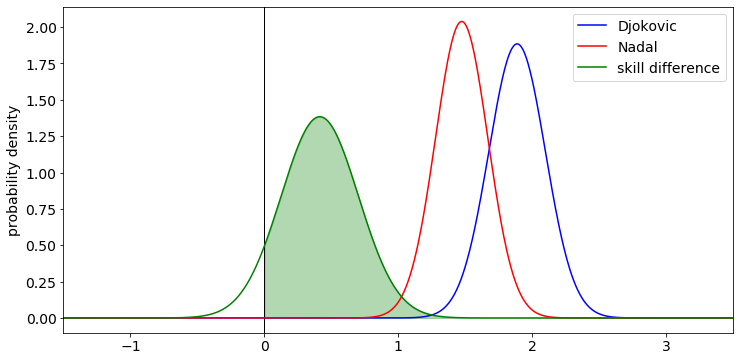

In [42]:
plt.figure(figsize=(12, 6))
plt.axvline(0, color='k', linewidth=1)
x = np.linspace(-1.5, 3.5, 1000)
plt.plot(x, norm.pdf(x, mu_djo, s_djo), color='b', label='Djokovic')
plt.plot(x, norm.pdf(x, mu_nad, s_nad), color='r', label='Nadal')

s = norm(mu_djo - mu_nad, np.sqrt(s_djo**2 + s_nad**2))
plt.plot(x, s.pdf(x), color='g', label='skill difference')
mask = x > 0
plt.fill_between(x[mask], s.pdf(x[mask]), 0, color='g', alpha=0.3)
plt.ylabel('probability density')
plt.legend()
plt.xlim(-1.5, 3.5)

In [43]:
prob_skill1_gt_skill2(mu_djo, s_djo**2, mu_nad, s_nad**2)

0.9244847132107417

### Joint skills
Approximate their joint skills as a 2-d Gaussian (take into account their covariance)

Text(0, 0.5, 'Nadal skill')

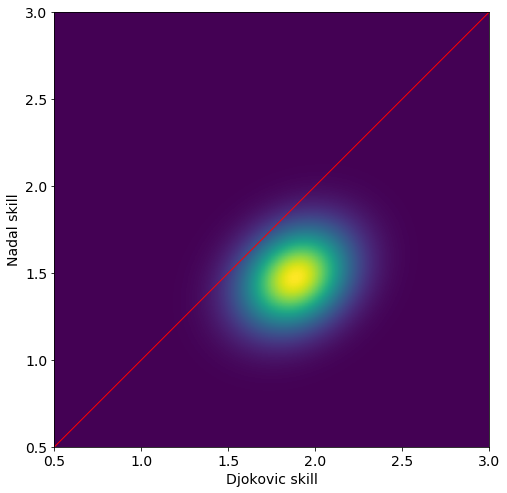

In [45]:
mu = np.array([mu_djo, mu_nad])
cov = np.cov(djo_skill_samples, nad_skill_samples)

x_min, x_max, y_min, y_max = 0.5, 3, 0.5, 3
x = np.linspace(x_min, x_max, 1000)
y = np.linspace(y_min, y_max, 1000)
X, Y = np.meshgrid(x, y)
XY = np.concatenate((np.expand_dims(X, -1), np.expand_dims(Y, -1)), -1)
Z = multivariate_normal.pdf(XY, mu, cov)

fig = plt.figure(figsize=(8, 8))
plt.imshow(Z, cmap='viridis', origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.plot([x_min, x_max], [y_min, y_max], linewidth=1, color='r')
plt.xlabel('Djokovic skill')
plt.ylabel('Nadal skill')

# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, multivariate_normal.pdf(XY, mu, cov), cmap='viridis', linewidth=0)

/Users/felixkok/Documents/uni/IIB/project/python_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


Text(0.5, 0, 'Probability density')

/Users/felixkok/Documents/uni/IIB/project/python_code/venv/lib/python3.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


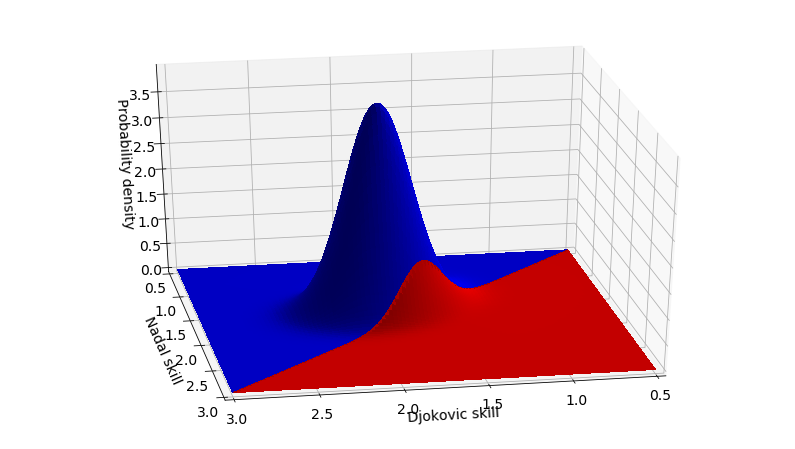

In [46]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib import cm

fig = plt.figure(figsize=(14, 8))
ax = fig.gca(projection='3d')

# light = LightSource(90, 45)
# illuminated_surface = light.shade(Z)

Z_ = np.copy(Z); Z_[X <= Y] = None
ax.plot_surface(X, Y, Z, linewidth=0, color='b', edgecolor='b', antialiased=False, cstride=10, rstride=10)
Z_ = np.copy(Z); Z_[X >= Y] = None
ax.plot_surface(X, Y, Z_, linewidth=0, color='r', edgecolor='r', antialiased=False, cstride=10, rstride=10)
ax.view_init(azim=80)
plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
ax.set_xlabel('Djokovic skill'); ax.set_ylabel('Nadal skill'); ax.set_zlabel('Probability density')

Probability that Djokovic has higher skill than Nadal: volume under blue surface

In [47]:
def prob_w1_gt_w2_joint(samples1, samples2):
    mu = np.mean(samples1) - np.mean(samples2)
    cov = np.cov(samples1, samples2)
    s = np.sqrt(cov[0, 0] + cov[1, 1] - 2 * cov[0, 1])
    return norm.cdf(mu / s) if s != 0 else 0

In [48]:
prob_w1_gt_w2_joint(djo_skill_samples, nad_skill_samples)

0.9478292558609094

### Comparing skills directly from samples
Calculate the probability empirically using Gibbs samples

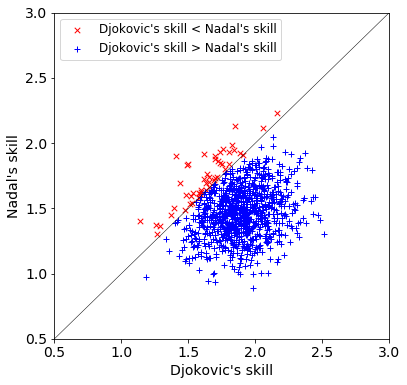

In [49]:
djo_skill_samples = skill_samples[djo_id, 200::10]
nad_skill_samples = skill_samples[nad_id, 200::10]

plt.figure(figsize=(6, 6))
plt.plot([0.5, 3], [0.5, 3], 'k', linewidth=0.5)

mask = djo_skill_samples >= nad_skill_samples
plt.scatter(djo_skill_samples[~mask], nad_skill_samples[~mask],
            color='r', marker='x', s=30, linewidth=1, label='Djokovic\'s skill < Nadal\'s skill')
plt.scatter(djo_skill_samples[mask], nad_skill_samples[mask],
            color='b', marker='+', s=45, linewidth=1, label='Djokovic\'s skill > Nadal\'s skill')
plt.xlim(0.5, 3); plt.ylim(0.5, 3)
plt.xlabel('Djokovic\'s skill'); plt.ylabel('Nadal\'s skill')
plt.legend(fontsize=12)

In [50]:
(djo_skill_samples > nad_skill_samples).sum(), (djo_skill_samples < nad_skill_samples).sum()

(930, 50)

In [51]:
def prob_w1_gt_w2_samples(samples1, samples2):
    return np.sum(samples1 > samples2) / samples1.shape[0]

In [52]:
prob_w1_gt_w2_samples(djo_skill_samples, nad_skill_samples)

0.9489795918367347

### 4x4 table of probabilities that one player has higher skill than the other, using the joint distribution

In [53]:
np.array([[prob_w1_gt_w2_joint(skill_samples[i].reshape(-1), skill_samples[j].reshape(-1))
           for j in top4_ids] for i in top4_ids])

array([[0.        , 0.94782926, 0.91882374, 0.98776186],
       [0.05217074, 0.        , 0.42901054, 0.77682613],
       [0.08117626, 0.57098946, 0.        , 0.80778633],
       [0.01223814, 0.22317387, 0.19221367, 0.        ]])

### 4x4 table of probabilities that one player has higher skill than the other, using direct samples

In [54]:
np.array([[prob_w1_gt_w2_samples(skill_samples[i].flatten(), skill_samples[j].flatten())
           for j in top4_ids] for i in top4_ids])

array([[0.    , 0.9509, 0.9212, 0.989 ],
       [0.0491, 0.    , 0.4322, 0.7752],
       [0.0788, 0.5678, 0.    , 0.8105],
       [0.011 , 0.2248, 0.1895, 0.    ]])

# Part e - ranking players

### Using empirical game outcome averages

In [69]:
def get_mean_game_outcome(G, p):
    """game outcome: +1 if win, -1 if lose"""
    games = (G == p).astype(np.int)
    return np.sum(games[:, 0]) / np.sum(games)

mean_game_outcomes = np.array([get_mean_game_outcome(G, p) for p in range(M)])

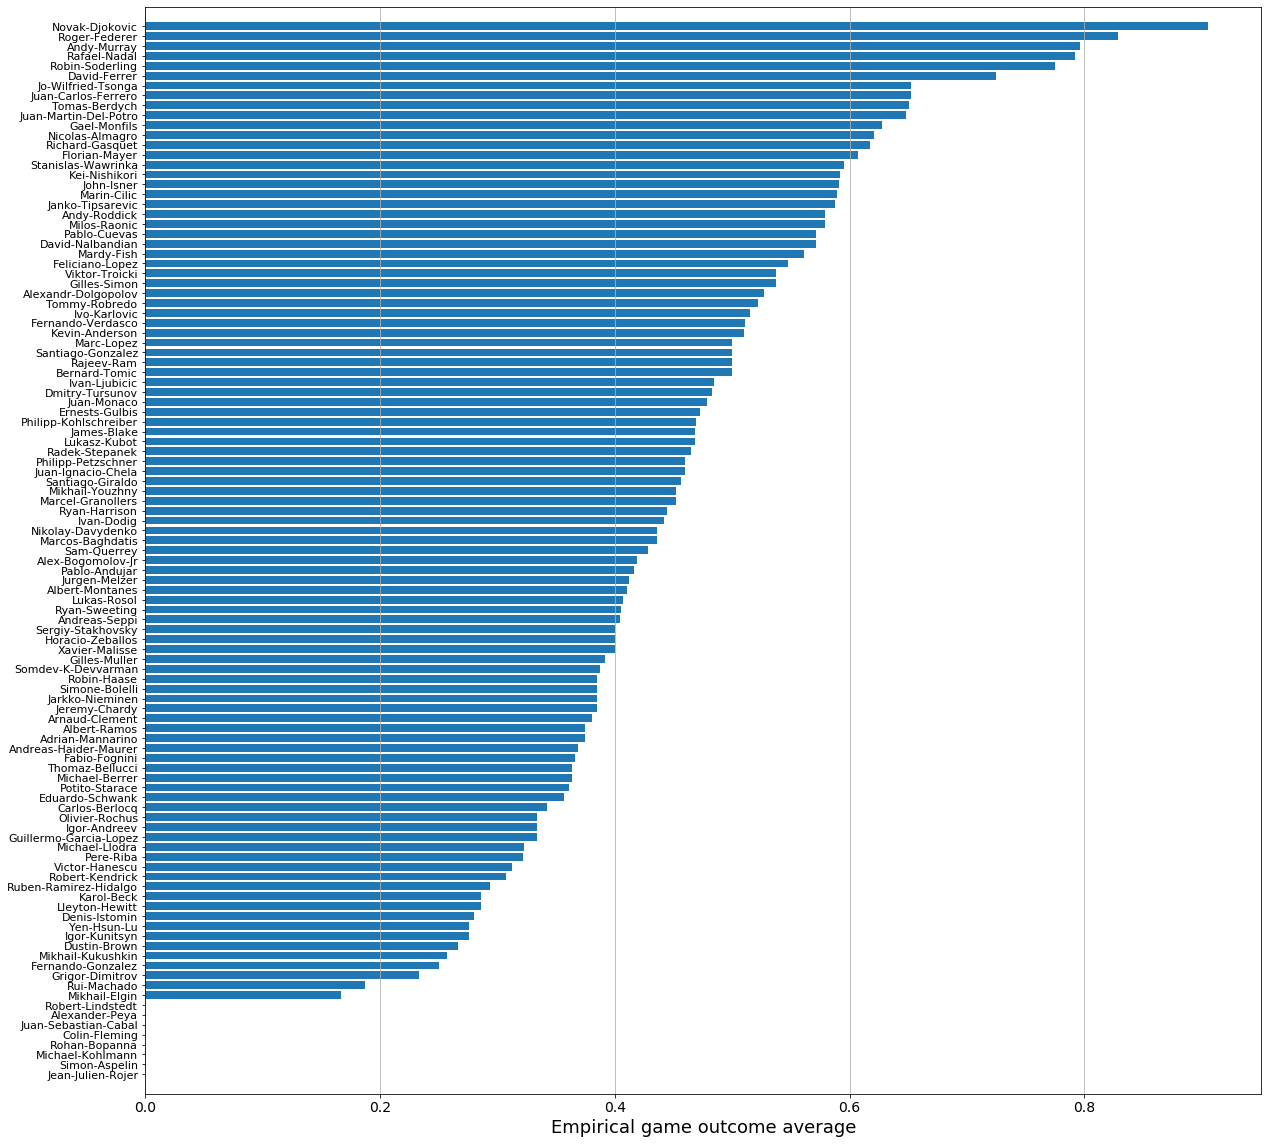

In [70]:
sorted_barplot(mean_game_outcomes, W.reshape(-1, 1))
plt.yticks(fontsize=11)
plt.xlabel('Empirical game outcome average', fontsize=18)
plt.grid(which='both', axis='x')

### Using Gibbs sampling
Create a 107x107 table recording the probability that one player wins a match against the other for all 107 players:

In [71]:
proba_table_gs = np.mean(norm.cdf(np.array([
    [s1 - s2 for s2 in skill_samples_thinned] for s1 in skill_samples_thinned
])), axis=-1)

In [72]:
mean_proba_gs = np.sum(proba_table_gs, axis=1) / (proba_table_gs.shape[-1] - 1)

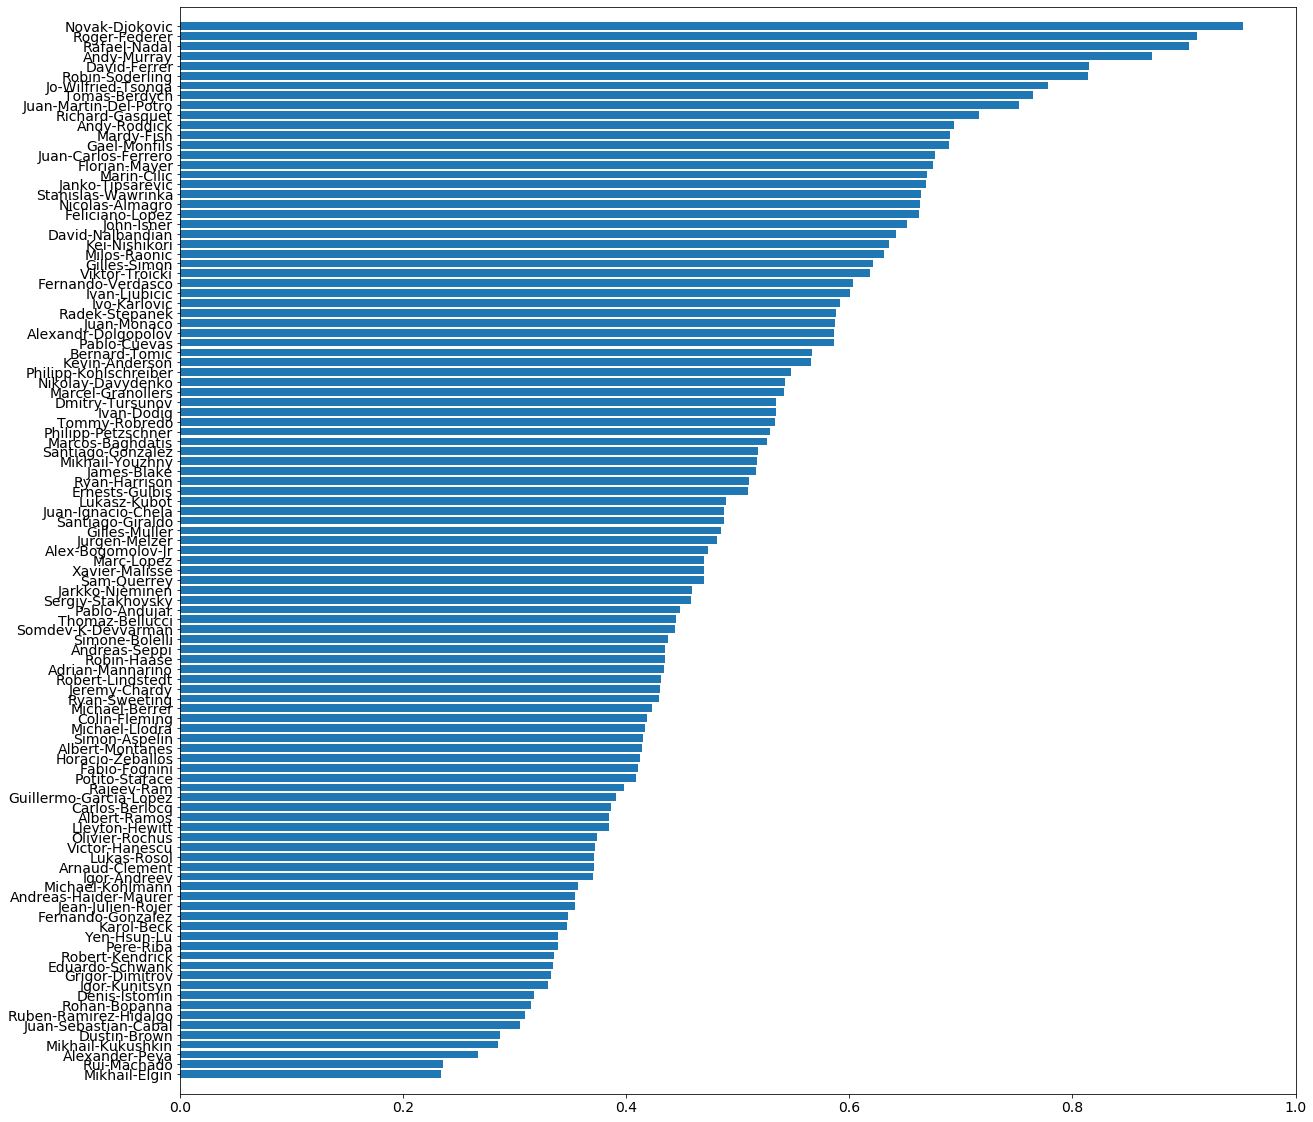

In [73]:
sorted_barplot(mean_proba_gs, W.reshape(-1, 1))

### Using message passing

In [74]:
proba_table_ep = np.array([
    [prob_p1_beats_p2(mu1, v1, mu2, v2) for mu2, v2 in zip(mean_player_skills_ep, var_player_skills_ep)]
for mu1, v1 in zip(mean_player_skills_ep, var_player_skills_ep)])

In [75]:
mean_proba_ep = np.sum(proba_table_ep, axis=1) / (proba_table_ep.shape[-1] - 1)

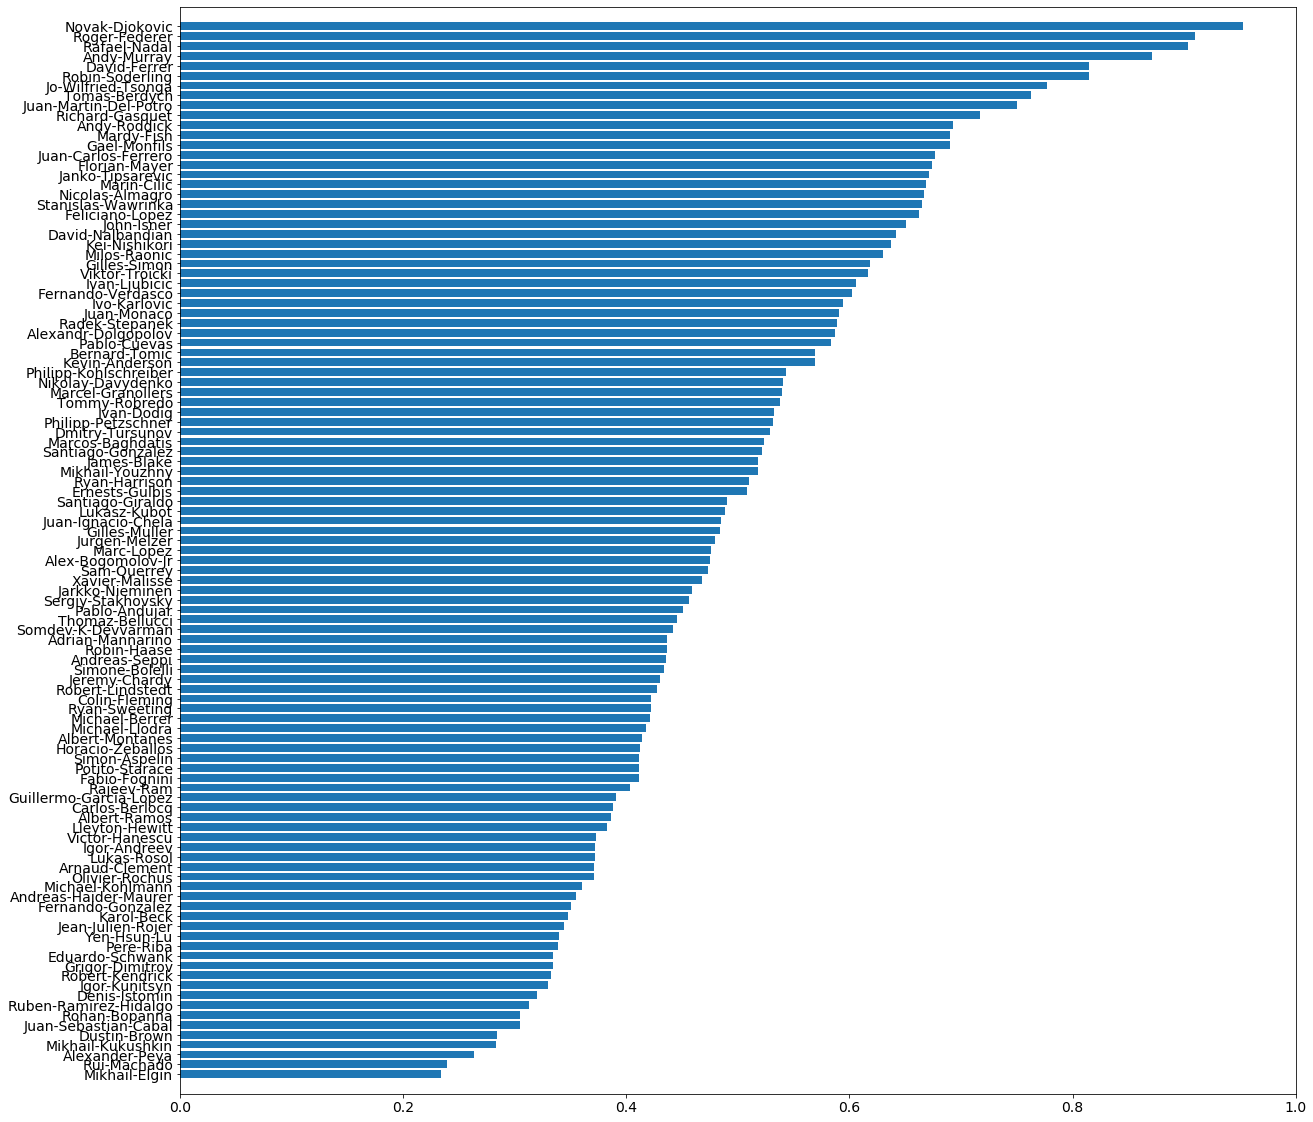

In [76]:
sorted_barplot(mean_proba_ep, W.reshape(-1, 1))

Compare results from Gibbs sampling and message passing:

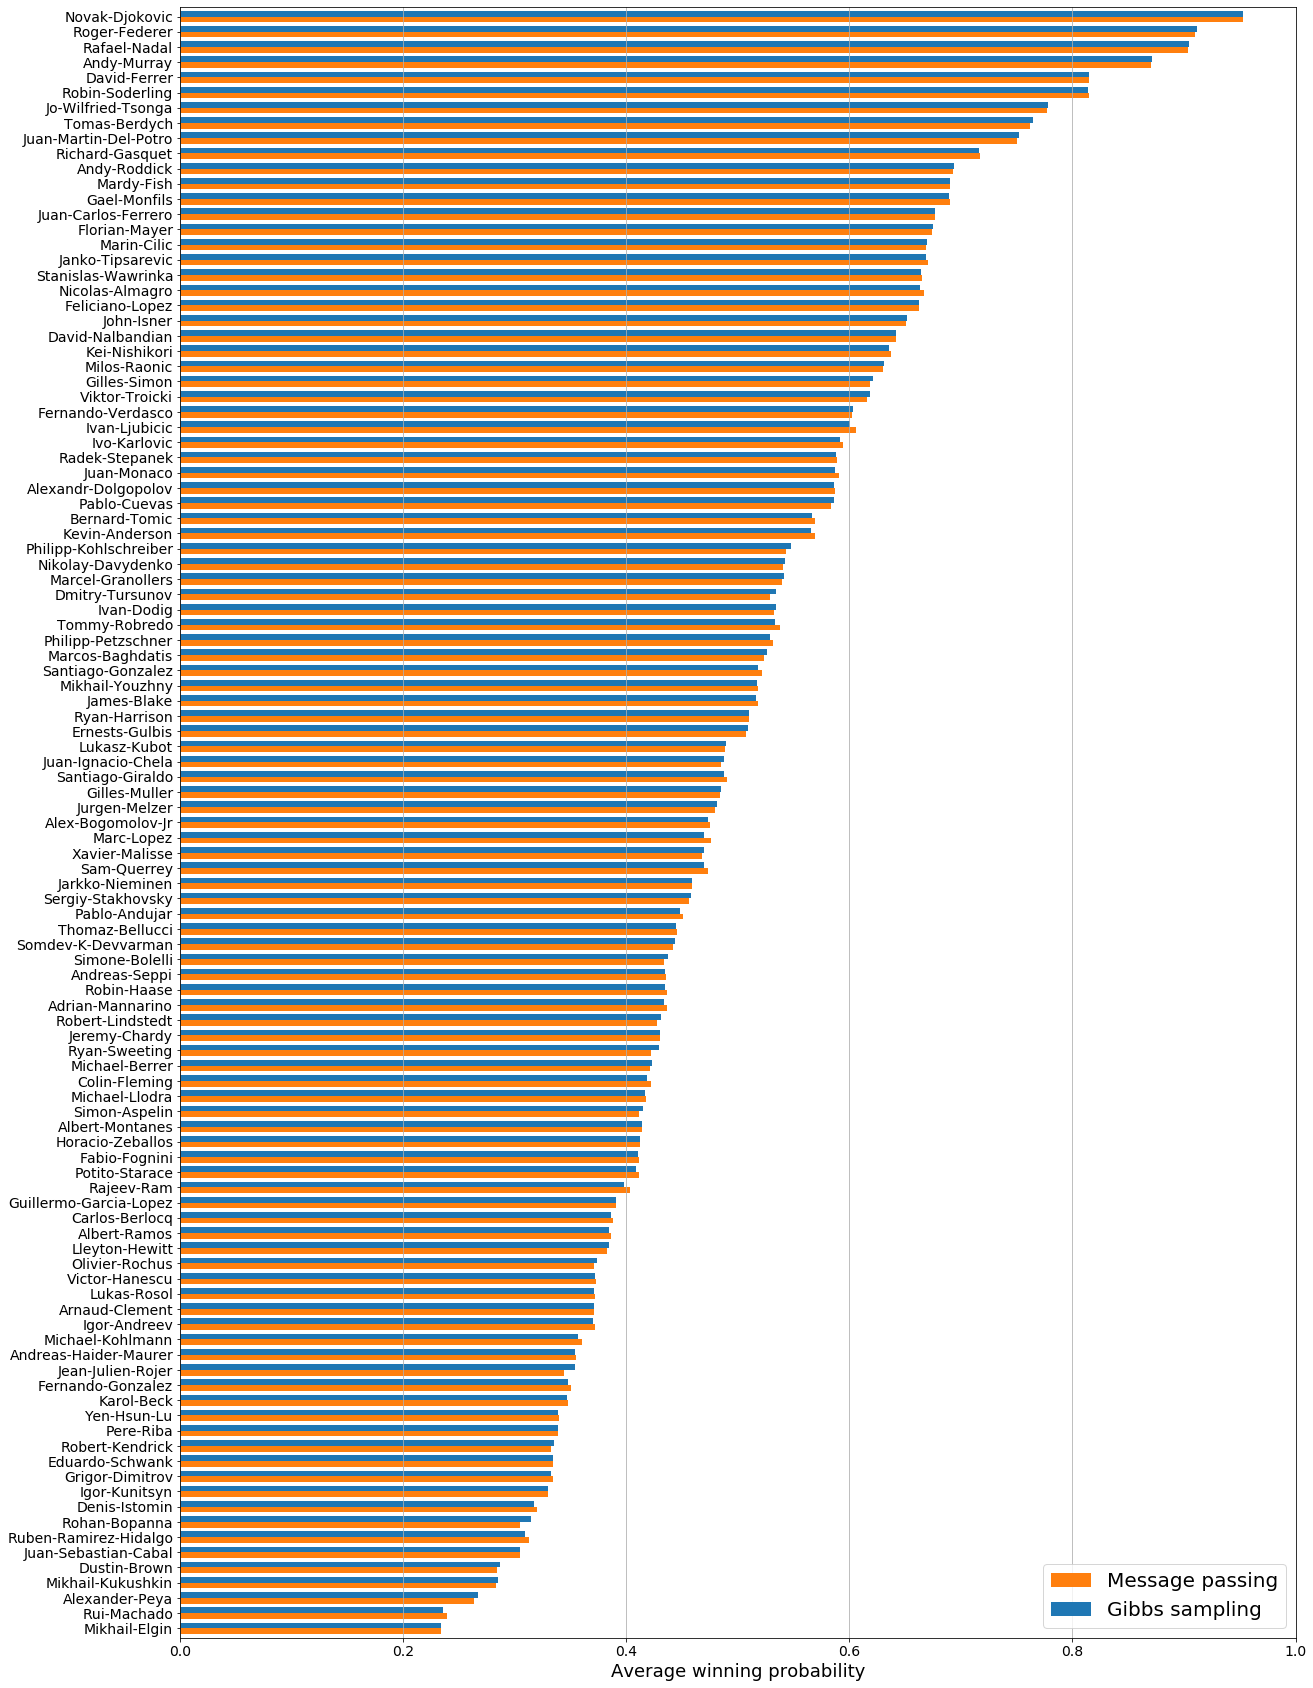

In [77]:
mean_proba = pd.DataFrame({
    'ep': mean_proba_ep,
    'gs': mean_proba_gs
}, index=W)

ax = mean_proba.sort_values(by=['gs', 'ep']).plot.barh(figsize=(20, 30), width=0.75, color=['tab:orange', 'tab:blue'])
ax.legend(['Message passing', 'Gibbs sampling'], fontsize=20)
plt.xlabel('Average winning probability', fontsize=18)
plt.grid(which='both', axis='x')

### Compare the rankings produced by the three methods

In [78]:
mean_skills_df = pd.DataFrame({
    'gs': mean_player_skills_gs,
    'ep': mean_player_skills_ep,
    'empirical': mean_game_outcomes
}, index=W)

mean_skills_df

,gs,ep,empirical
Rafael-Nadal,1.481409,1.471553,0.791667
Juan-Monaco,0.230718,0.240796,0.478261
Juan-Martin-Del-Potro,0.763167,0.756361,0.648148
Mardy-Fish,0.546575,0.550049,0.561404
Roger-Federer,1.530237,1.519088,0.828571
...,...,...,...
Michael-Kohlmann,-0.508183,-0.485945,0.000000
Simon-Aspelin,-0.308104,-0.314826,0.000000
Mikhail-Elgin,-0.908058,-0.913781,0.166667
Robert-Lindstedt,-0.253752,-0.262602,0.000000


In [84]:
mean_skills_df_sorted = mean_skills_df.sort_values(by=['gs', 'ep'], ascending=False)

In [85]:
gs_skills = mean_skills_df_sorted['gs']
ep_skills = mean_skills_df_sorted['ep']
emp_skills = mean_skills_df_sorted['empirical']

In [86]:
ordered_rankings = list(range(1, len(gs_ranked_players) + 1))

gs_rankings = pd.Series(ordered_rankings, index=gs_skills.index)
gs_ranked_players = gs_rankings.index

ep_rankings = pd.Series(ordered_rankings, index=ep_skills.sort_values(ascending=False).index)

emp_skills_sorted = emp_skills.sort_values(ascending=False)
emp_rankings = pd.Series(ordered_rankings, index=emp_skills_sorted.index)

for i in range(emp_rankings.shape[0] - 1, 0, -1):
    if emp_skills_sorted.iloc[i] == emp_skills_sorted.iloc[i-1]:
        emp_rankings.iloc[i] = np.nan

emp_rankings.fillna(method='ffill', inplace=True)

rankings_df = pd.DataFrame({
    'emp': emp_rankings.loc[gs_ranked_players],
    'ep': ep_rankings.loc[gs_ranked_players],
    'gs': gs_rankings
})

rankings_df

,emp,ep,gs
Novak-Djokovic,1.0,1,1
Roger-Federer,2.0,2,2
Rafael-Nadal,4.0,3,3
Andy-Murray,3.0,4,4
Robin-Soderling,5.0,5,5
...,...,...,...
Mikhail-Kukushkin,95.0,103,103
Dustin-Brown,94.0,104,104
Alexander-Peya,100.0,105,105
Rui-Machado,98.0,106,106


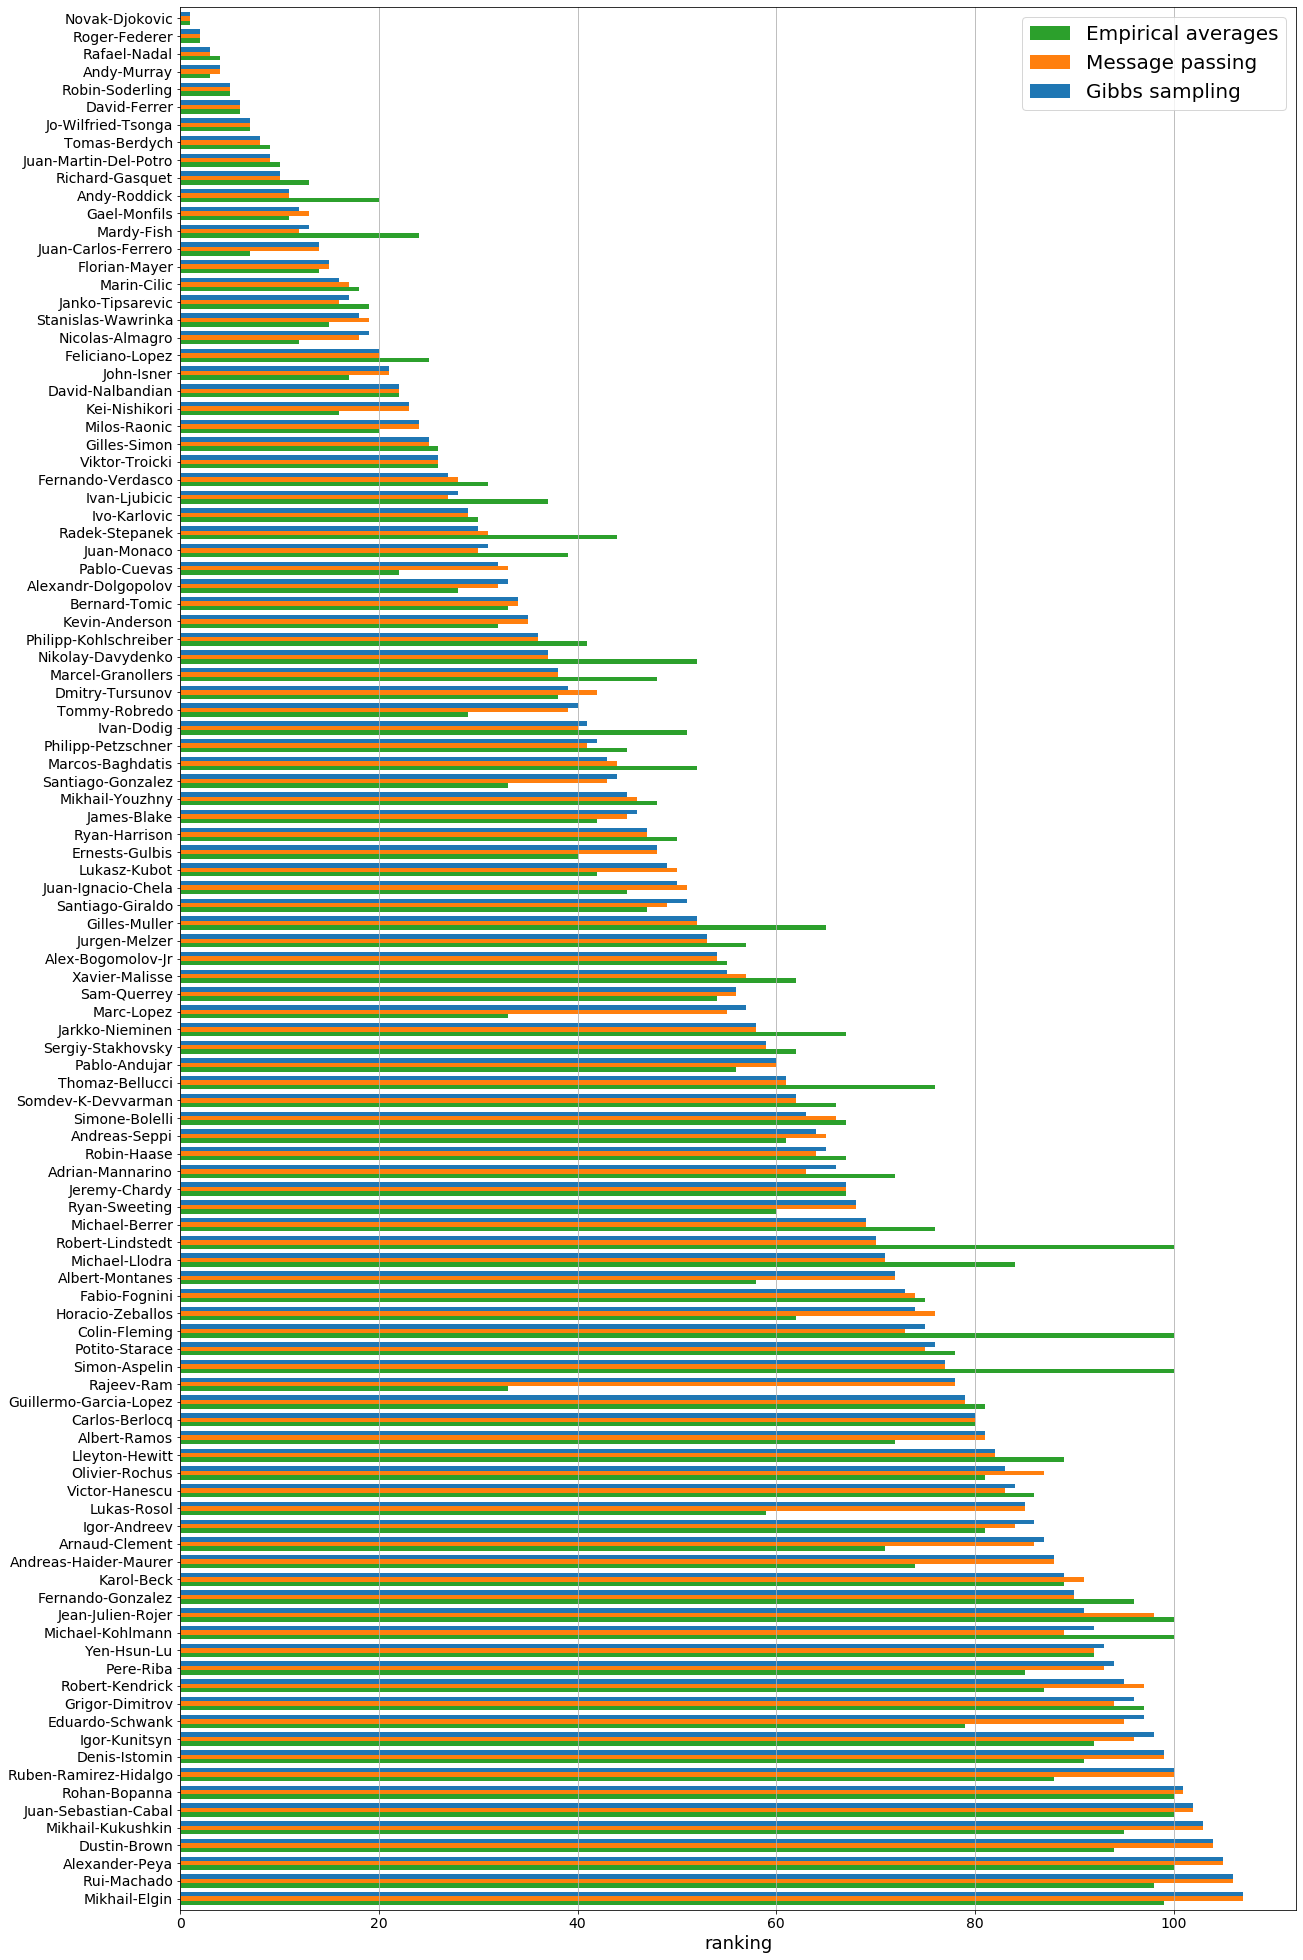

In [87]:
ax = rankings_df.iloc[::-1].plot.barh(figsize=(20, 35), width=0.75, color=['tab:green', 'tab:orange', 'tab:blue'])
ax.legend(['Empirical averages', 'Message passing', 'Gibbs sampling'], fontsize=20)
plt.xlabel('ranking', fontsize=18)
plt.grid(which='both', axis='x')